In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import math
import numpy as np

!pip install transformers

from transformers import AutoTokenizer, AutoConfig, AutoModel
from transformers import BertTokenizer, BertModel


!pip install tqdm
!pip install datasets
import json
from tqdm import tqdm
from datasets import Dataset as ds
import random
import json

import os  # when loading file paths
import pandas as pd  # for lookup in annotation file
import torch
from torch.nn.utils.rnn import pad_sequence  # pad batch
from torch.utils.data import DataLoader, Dataset

from google.colab import drive
drive.mount('/content/drive')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 58.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 58.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.3 MB/s eta 0:00:00
Mounted at /content/drive
cuda


In [2]:
# file_path = r"/content/drive/MyDrive/IRE/project/train_chaii_hi_1.json"
# train_file_path = r"/content/drive/MyDrive/IRE/project/train.json"
# test_file_path = r"/content/drive/MyDrive/IRE/project/test.json"

file_path = r"/content/drive/MyDrive/IRE/train_chaii_hi_1.json"
train_file_path = r"/content/drive/MyDrive/IRE/train.json"
test_file_path = r"/content/drive/MyDrive/IRE/test.json"

In [3]:
def load_data(file):

  # Specify the path to your JSON file
  json_file_path = file
  # Initialize an empty dictionary
  data = {}

  # Load the JSON data into the dictionary
  try:
      with open(json_file_path, "r") as json_file:
          data = json.load(json_file)
      print("JSON file loaded successfully into a dictionary.")
  except FileNotFoundError:
      print(f"Error: JSON file '{json_file_path}' not found.")
  except json.JSONDecodeError as e:
      print(f"Error decoding JSON: {e}")
  except Exception as e:
      print(f"An error occurred: {e}")

  return data

train_dict = load_data(train_file_path)
test_dict = load_data(test_file_path)
print("len(train_dict): ", len(train_dict))
print("len(test_dict): ", len(test_dict))

chai_dataset = {
  "train": {"question": [], "positivie_context": [], "negative_context": []},
  "test": {"question": [], "positivie_context": [], "negative_context": []},
}

def get_data(split_type, dict_type, chai_dataset, k):

  question_list = []
  positive_contest_list = []
  negative_contest_list = []
  random_seed = 42
  random.seed(random_seed)
  for i in dict_type:
    question_list.append(i['question'])
    positive_contest_list.append(i["positive_ctxs"][0]['text'])

  for i in range(len(positive_contest_list)):
    list1 =[]
    for j in range(len(positive_contest_list)):
      if(i!=j):
        list1.append(positive_contest_list[j])
    list1 = random.choices(list1, k=k)
    negative_contest_list.append(list1[:])

  for i in range(len(question_list)):
    chai_dataset[split_type]["question"] = question_list
    chai_dataset[split_type]["positivie_context"] = positive_contest_list
    chai_dataset[split_type]["negative_context"] = negative_contest_list

#build train
get_data("train", train_dict, chai_dataset, 10)

#build test
get_data("test", test_dict, chai_dataset, 10)

class chaiDataset(Dataset):
  def __init__(self, dataset_object, split_type):
    #convert list to pandas datafraame
    #create new df
    # split_type = 'train'

    self.df = pd.DataFrame({'question':dataset_object[split_type]['question'],'positivie_context':dataset_object[split_type]['positivie_context'],'negative_context':dataset_object[split_type]['negative_context']})
    # print ("df:",self.df)

    # Get question columns
    self.question = self.df["question"]
    # Get positive_context columns
    self.positivie_context = self.df["positivie_context"]
    # Get the negative_context columns
    self.negative_context = self.df["negative_context"]

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    question = self.question[index]
    positive_context = self.positivie_context[index]
    negative_context = self.negative_context[index]

    return question, positive_context

def get_loader(
    dataset_object,
    split_type,
    batch_size=1,
    shuffle=True,
):
  dataset = chaiDataset(chai_dataset, split_type)

  loader = DataLoader(
      dataset=dataset,
      batch_size=batch_size,
      shuffle=shuffle,
  )

  return loader, dataset

JSON file loaded successfully into a dictionary.
JSON file loaded successfully into a dictionary.
len(train_dict):  596
len(test_dict):  149


In [4]:
test_dataset_object = chai_dataset["test"]
train_dataset_object = chai_dataset["train"]
test_split_type = "test"
train_split_type = "train"
batch_size = 8
test_dataloader, test_dataset = get_loader(test_dataset_object, test_split_type, batch_size)
train_dataloader, train_dataset = get_loader(train_dataset_object, train_split_type, batch_size)

In [5]:
class Encoder(nn.Module):
    def __init__(self, model_name):
        super(Encoder, self).__init__()
        # cfg_name = "bert-base-uncased"
        # self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.tokenizer = BertTokenizer.from_pretrained(model_name)
        cfg = AutoConfig.from_pretrained(model_name)
        # self.BertModel= AutoModel.from_pretrained(model_name, config=cfg) # , project_dim=projection_dim, **kwargs
        self.BertModel = BertModel.from_pretrained(model_name)

    def forward(self, x):
        # inputs = tokenizer(x, return_tensors='pt')
        # print("x = ", x)
        # input_ids = self.tokenizer.encode(x, add_special_tokens=True, return_tensors='pt')
        # print("tokenized x shape = ", input_ids.shape)
        # input_ids = x.unsqueeze(0)
        # print("tokenized x = ", input_ids)
        tokenized_batch = self.tokenizer(x, padding=True, truncation=True, add_special_tokens=True, return_tensors='pt')

        input_ids = tokenized_batch['input_ids']
        # print("input_ids shape  ", input_ids.shape)
        attention_mask = tokenized_batch['attention_mask']
        token_type_ids = tokenized_batch['token_type_ids']
        # print("outputs shape = ", outputs.shape)

        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        token_type_ids = token_type_ids.to(device)

        outputs = self.BertModel(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

        cls_embeddings = outputs.last_hidden_state[:, 0, :]
        # print("cls shape = ", cls_embeddings.shape)
        # cls_embeddings = cls_embeddings.reshape(cls_embeddings.size()[1])
        # print("output shape= ", outputs.shape)
        # print("outputs = ", outputs)
        # out  = outputs[0]
        # print("first output shape= ", cls_embeddings.shape)
        # print("first output = ", cls_embeddings)
        return cls_embeddings

In [6]:
class BiEncoder(nn.Module):
    def __init__(self, model_name):
        super(BiEncoder, self).__init__()
        self.model_name = model_name
        self.Q_Encoder = Encoder(model_name)
        self.P_Encoder = Encoder(model_name)

    def forward(self, question, PositiveDoc):
        q_emb = self.Q_Encoder(question)
        p_emb = self.P_Encoder(PositiveDoc)

        # neg_embs = []
        # for NegativeDoc in NegativeDocs:
        #     n_emb = self.P_Encoder(NegativeDoc)
        #     neg_embs.append(n_emb)

        return  q_emb, p_emb

In [7]:
# def CalculateSim(a, b):
#     a = a.numpy()
#     b = b.numpy()
#     return np.dot(a, b)


# def RetrieveSimilarityScores(q_emb, p_emb, n_embs):
#     Similarity_Scores = []

#     Similarity_Scores.append(CalculateSim(q_emb, p_emb))
#     for n_emb in n_embs:
#         Similarity_Scores.append(CalculateSim(q_emb, p_emb))

#     return np.array(Similarity_Scores)

In [8]:
# class CustomLoss(nn.Module):
#     def __init__(self):
#         super(CustomLoss, self).__init__()
#         # sftmax = nn.softmmax(dim=-1)

#     def forward(self, q_emb, p_emb):
#         Similarity_Scores = []

#         Similarity_Scores.append(self.CalculateSim(q_emb, p_emb))
#         # for n_emb in n_embs:
#         #     Similarity_Scores.append(self.CalculateSim(q_emb, n_emb))

#         # Similarity_Scores = np.array(Similarity_Scores)
#         # Similarity_Scores = np.exp(Similarity_Scores)

#         num  = Similarity_Scores[0]
#         den = np.sum(Similarity_Scores)
#         loss = -1 * math.log(num/den)

#         return torch.tensor(loss)

#     def CalculateSim(self, _a, _b):
#         a = _a
#         b = _b
#         a = a.detach().numpy()
#         # print(a.shape)
#         # print(b.shape)
#         b = b.detach().numpy()
#         return np.dot(a, b)


In [24]:
EPOCHS = 5
model_name = "bert-base-multilingual-uncased"
model = BiEncoder(model_name).to(device)
# model

In [10]:
def Train_BiEncoder(p_model, Dataloader, loss_func, optimizer):
    TotalLoss = 0
    for q, p_ctx in tqdm(Dataloader):

        optimizer.zero_grad()
        q = list(q)
        p_ctx = list(p_ctx)
        # q = q.to(device)
        # p_ctx = p_ctx.to(device)
        q_emb, p_emb = p_model(q, p_ctx)

        # print("q: ", q_emb.shape)
        # print(p_emb.shape)
        p_emb = torch.transpose(p_emb, 0, 1)
        r = torch.matmul(q_emb, p_emb)
        softmax_scores = F.log_softmax(r, dim=1)
        positive_idx_per_question = [x for x in range(softmax_scores.size(0))]

        # list(map(lambda x : x in for x in range(softmax_scores.size(0))))

        loss = F.nll_loss(
            softmax_scores,
            torch.tensor(positive_idx_per_question).to(softmax_scores.device),
            reduction="mean",
        )
        # loss = loss_func(q_emb, p_emb, n_embs)
        TotalLoss  = TotalLoss + loss.item()

        loss.backward()
        optimizer.step()

    return TotalLoss

100%|██████████| 75/75 [01:43<00:00,  1.38s/it]


EPOCH -  1
TRAIN LOSS= 88.23345726239495

Model Saved


100%|██████████| 75/75 [01:41<00:00,  1.36s/it]


EPOCH -  2
TRAIN LOSS= 42.86647095531225

Model Saved


100%|██████████| 75/75 [01:41<00:00,  1.35s/it]


EPOCH -  3
TRAIN LOSS= 23.535535551956855

Model Saved


100%|██████████| 75/75 [01:38<00:00,  1.32s/it]


EPOCH -  4
TRAIN LOSS= 23.679902803181903



100%|██████████| 75/75 [01:38<00:00,  1.31s/it]


EPOCH -  5
TRAIN LOSS= 21.114120469021145

Model Saved


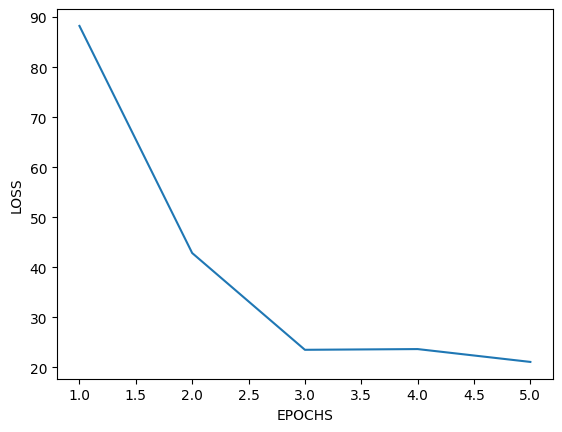

In [25]:
import matplotlib.pyplot as plt

def LoadOrTrainModel(p_model, Dataloader, loss_function, optimizer, SavedModel = None):
    # Loading Model

    if SavedModel != None:
        p_model = torch.load(SavedModel).to(device)
        print("Model Loaded succesfully")
        return p_model

    # Training Model
    minTrainLoss = float('inf')
    loss = []
    for epoch in range(EPOCHS):
        TrainLoss = Train_BiEncoder(p_model, Dataloader, loss_function, optimizer)

        print("EPOCH - ", epoch+1)
        print("TRAIN LOSS=", TrainLoss)
        print("")
        if TrainLoss < minTrainLoss:
            torch.save(p_model, 'DPR.pt')
            minTrainLoss = TrainLoss
            print("Model Saved")

        loss.append(TrainLoss)

    epochs = [i+1 for i in range(EPOCHS)]
    plt.plot(epochs, loss)
    plt.xlabel("EPOCHS")
    plt.ylabel("LOSS")

    plt.show()

    p_model = torch.load('DPR.pt').to(device)
    return p_model

# loss_func = CustomLoss()
loss_func = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

model = LoadOrTrainModel(model, train_dataloader, loss_func, optimizer) #, "/content/drive/MyDrive/IRE/DPR.pt"
model = model.to(device)


In [12]:
train_dataloader_new, train_dataset_new = get_loader(train_dataset_object, train_split_type, 1)

In [13]:
def ComputePassageEmbeddings(p_model, Dataloader):
    Pass_Emb = []
    Orginal_Passages = []
    for q, p_ctx in tqdm(Dataloader):
        q = q[0]
        p_ctx = p_ctx[0]
        # print(type(q))
        # print(type(p_ctx))
        # print(p_ctx)
        # print(q)
        Orginal_Passages.append(p_ctx)
        out = p_model.P_Encoder(p_ctx)
        out = out.cpu().detach()
        Pass_Emb.append(out)
        # break
    return Orginal_Passages, Pass_Emb


Org_Docs, SavedPassageEmbeddings = ComputePassageEmbeddings(model, train_dataloader_new)

100%|██████████| 596/596 [00:54<00:00, 10.99it/s]


In [20]:
def RetrieveTopKDocuments(p_model, Question, SavedPassageEmbeddings, Org_Docs, TopK):
    q_emb = p_model.Q_Encoder(Question)
    q_emb = q_emb.cpu().detach()
    sim_Dict = {}

    retrievedDocs = []
    for i in range(len(SavedPassageEmbeddings)):
        sim_Dict[i] = CalculateSim(q_emb, SavedPassageEmbeddings[i])

    sorted_SimDict = dict(sorted(sim_Dict.items(), key=lambda x:x[1], reverse=True)[:TopK])

    for i, k in enumerate(sorted_SimDict.keys()):
        print("RANK -", i+1, " -> Document - ", k, )
        # print(Org_Docs[k])
        # print()
        retrievedDocs.append(Org_Docs[k])

    return retrievedDocs

def CalculateSim(a, b):
        return torch.matmul(a, b.transpose(0, 1))
        # a = a.numpy()
        # b = b.numpy()
        # return np.dot(a, b)

In [21]:
Question = "विद्याधर शास्त्री को भारत के राष्ट्रपति द्वारा किस उपाधि से सम्मानित किया गया था?"

dos = RetrieveTopKDocuments(model, Question, SavedPassageEmbeddings, Org_Docs, 3)

RANK - 1  -> Document -  577
RANK - 2  -> Document -  127
RANK - 3  -> Document -  155


In [22]:
Question = "चीन के सर्वप्रथम जनकवि किसे माना जाता हैं?"

dos = RetrieveTopKDocuments(model, Question, SavedPassageEmbeddings, Org_Docs, 3)

RANK - 1  -> Document -  253
RANK - 2  -> Document -  470
RANK - 3  -> Document -  477


In [23]:
Question = "अर्नेस्ट रदरफोर्ड, किस पेशे से सम्बंधित थे?"

dos = RetrieveTopKDocuments(model, Question, SavedPassageEmbeddings, Org_Docs, 3)

RANK - 1  -> Document -  142
RANK - 2  -> Document -  323
RANK - 3  -> Document -  334


In [ ]:
enc = Encoder("bert-base-multilingual-uncased").to(device)

li = ["यह हिंदी में एक उदाहरण पाठ है जिसके लिए हम एम्बेडिंग चाहते हैं।", "यह हिंदी में एक उदाहरण पाठ है जिसके लिए हम एम्बेडिंग चाहते हैं।", "यह हिंदी में एक उदाहरण पाठ है जिसके लिए हम एम्बेडिंग चाहते हैं।"]

t = enc("यह हिंदी में एक उदाहरण पाठ है जिसके लिए हम एम्बेडिंग चाहते हैं।")
print(t.shape, t)

torch.Size([1, 768]) tensor([[-4.9894e-02, -8.0586e-03,  3.8345e-02, -1.2520e-02, -3.0353e-01,
          3.4672e-02, -6.1347e-02, -2.8250e-02, -1.9716e+00, -2.6257e-02,
         -7.3716e-02, -1.1618e-01,  4.5818e-02,  2.1139e-02,  7.3459e-02,
          1.8165e-01,  8.6634e-02, -1.6661e-02, -2.4273e-02, -9.5362e-02,
         -6.2225e-02,  9.8234e-02, -1.2547e-02, -1.1346e-01,  5.2281e-01,
         -4.5976e-02,  5.6888e-02, -1.1539e-02, -2.1525e+00,  3.0079e-02,
         -2.5891e-01,  7.1424e-02, -5.9477e-02,  7.7307e-03,  4.6159e-03,
         -4.9036e-02,  4.5733e-02,  1.5815e+00, -6.5619e-02, -8.1851e-02,
         -5.5727e-03,  5.4165e-02, -1.2148e-01,  1.1054e-01, -2.3002e-02,
         -9.9618e-02,  6.5950e-03,  3.1343e-03, -2.9284e-02, -4.9691e-02,
         -7.5719e-02,  1.5607e-01, -2.7144e-02, -3.0273e-02, -5.1044e-02,
         -1.1327e-02, -6.5412e-02,  5.4875e-03,  5.8851e-02,  6.7002e-02,
          1.8865e+00,  8.5250e-02, -7.7812e-02,  4.9610e-02, -2.6498e-03,
          2.8578e

In [ ]:
print(enc)